In [1]:
import warnings
# ignore warnings
warnings.filterwarnings('ignore')

### Import Libraries and other Dependencies

In [2]:
# importing necessary libraries
% matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras import layers
from keras.models import load_model 
from scipy.stats import pearsonr
from math import sqrt
import re

Using TensorFlow backend.


### Load and Prepare the Dataset

In [3]:
def loadText(file):
    with open(file, 'r') as text:
        doc = text.readlines()
    return doc

In [4]:
train_articles = loadText('train.txt')

In [5]:
train_doc = train_articles
train_doc[:5]

['Test to predict breast cancer relapse is approved\n',
 'Two Hussein allies are hanged, Iraqi official says\n',
 'Sights and sounds from CES\n',
 'Schuey sees Ferrari unveil new car\n',
 'Closings and cancellations top advice on flu outbreak\n']

In [6]:
print("size of train set: {}".format(len(train_doc)))

size of train set: 1000


In [7]:
test_articles = loadText('test.txt')

In [8]:
test_doc = test_articles
test_doc[:5]

['Mortar assault leaves at least 18 dead\n',
 'Goal delight for Sheva\n',
 'Nigeria hostage feared dead is freed\n',
 'Bombers kill shoppers\n',
 'Vegetables, not fruit, slow brain decline\n']

In [9]:
print("size of test set: {}".format(len(test_doc)))

size of test set: 246


In [10]:
label = loadText('label.txt')

In [11]:
label[:5]

['0 0 15 38 9 11\n',
 '24 26 16 13 38 5\n',
 '0 0 0 17 0 4\n',
 '0 0 0 46 0 31\n',
 '1 0 23 8 11 8\n']

In [12]:
print("size of label set: {}".format(len(label)))

size of label set: 1000


### Preprocessing Data for Training

In [13]:
def preProcesslabel(label):
    # split into individual digits
    labels = [x.split() for x in label]
    # remove punctuations from digits
    labels = [[int(num) for num in line]
              for line in labels]
    return _normalze(labels)

def _normalze(label):
    labels = np.array(label)
    # normalize labels 
    return normalize(labels, norm='l1', axis=1)

labels = preProcesslabel(label)

In [14]:
labels[:5]

array([[0.        , 0.        , 0.20547945, 0.52054795, 0.12328767,
        0.15068493],
       [0.19672131, 0.21311475, 0.13114754, 0.10655738, 0.31147541,
        0.04098361],
       [0.        , 0.        , 0.        , 0.80952381, 0.        ,
        0.19047619],
       [0.        , 0.        , 0.        , 0.5974026 , 0.        ,
        0.4025974 ],
       [0.01960784, 0.        , 0.45098039, 0.15686275, 0.21568627,
        0.15686275]])

In [15]:
# histogram and plots of text lengths
def textLengths(article, hist=False): 
    text_lengths = [len(line) for line in article]
    ax = plt.gca()        
    if hist:
        _hist(ax, text_lengths)
    else:
        _plot(ax, text_lengths)
        
def _plot(ax, text_lengths):
    # plots
    ax.plot(text_lengths, color='b')
    ax.set_xlabel('Sentence Index')
    ax.set_ylabel('Number of Words')
    ax.set_title('Plot of Number ' 
                 'of Words in a Text')
    
def _hist(ax, text_lengths):
    # histogram sentence size
    ax.hist(text_lengths, bins=10, color='r')
    ax.set_xlabel('Number of Words in a Text')
    ax.set_ylabel('Number of Texts')
    ax.set_title('Histogram of Number ' 
                 'of Words in a Text')

Train set


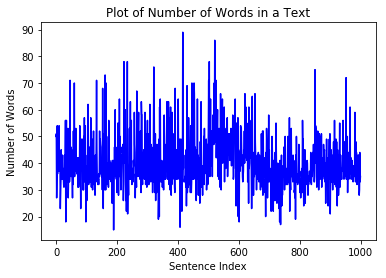

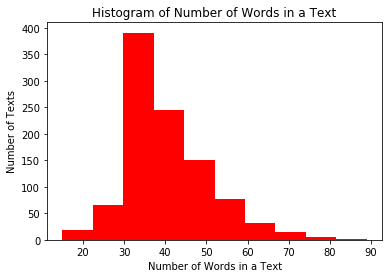

In [16]:
print('Train set')
plt.show(textLengths(train_doc))
plt.show(textLengths(train_doc, hist=True))

Test Set


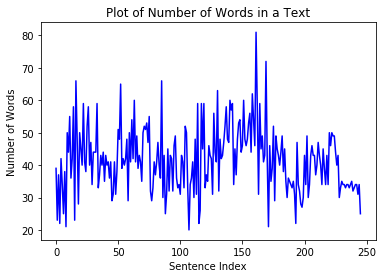

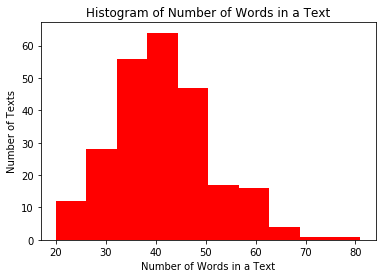

In [17]:
print('Test Set')
plt.show(textLengths(test_doc))
plt.show(textLengths(test_doc, hist=True))

In [18]:
def removePunctuations(article, lower=True):
    no_punctuation = [re.sub('[,\.!?]', '', text) 
                          for text in _to_lower_case(article)]
    return no_punctuation

# helper fuction to change texts to lower case
def _to_lower_case(article):
    lower_case = [text.lower() for text in article]
    return lower_case

In [19]:
train_doc = removePunctuations(train_doc)
test_doc = removePunctuations(test_doc)

In [20]:
# splitting data into 75.4% train and 24.6% validation data
val_size = 0.246
texts_train, texts_val, label_train, label_val = train_test_split(
    train_doc, labels, test_size=val_size, random_state=42) 
print("size of training set:", len(texts_train))
print("size of validation set:", len(texts_val))
print("size of label training set:", len(label_train))
print("size of label validation set:", len(label_val))

size of training set: 754
size of validation set: 246
size of label training set: 754
size of label validation set: 246


In [21]:
# splitting texts into tokens
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts_train)
# changing tokens into into sequence of numbers
train_data_seq = tokenizer.texts_to_sequences(texts_train)
val_data_seq = tokenizer.texts_to_sequences(texts_val)
test_data_seq = tokenizer.texts_to_sequences(test_doc)

In [22]:
# padding sequence of numbers with sequence lenght of 50
seq_len = 50
train_texts = sequence.pad_sequences(train_data_seq, maxlen=seq_len)
val_texts = sequence.pad_sequences(val_data_seq, maxlen=seq_len)
test = sequence.pad_sequences(val_data_seq, maxlen=seq_len)

In [23]:
print('train data shape:', train_texts.shape)
print('validation data shape:', val_texts.shape)
print('test data shape:', test.shape)

train data shape: (754, 50)
validation data shape: (246, 50)
test data shape: (246, 50)


In [24]:
# one-hot encoding labels into size of class
num_classes = 6
train_label = to_categorical(label_train, num_classes=num_classes)
val_label = to_categorical(label_val, num_classes=num_classes)

### Defining Model Architecture

In [25]:
# defining model architecture
out_dim = 128
n_units = 32
vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(vocab_size, out_dim, input_length=seq_len))
model.add(LSTM(n_units))
model.add(Dense(n_units, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) 

In [26]:
# displaying model achitecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           313216    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 335,078
Trainable params: 335,078
Non-trainable params: 0
_________________________________________________________________


### Model Trainning and Performance Visualization

In [27]:
# defining model evaluation parameters
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy']) 

In [28]:
# model training for 3 epochs
history = model.fit(train_texts, label_train,
                    batch_size=32, epochs=10,
                    validation_data=(val_texts, label_val))

Train on 754 samples, validate on 246 samples
Epoch 1/10
754/754 [==============================] - 50s 66ms/step - loss: 1.7072 - acc: 0.3634 - val_loss: 1.6657 - val_acc: 0.3496
Epoch 2/10
754/754 [==============================] - 18s 24ms/step - loss: 1.6454 - acc: 0.3660 - val_loss: 1.6450 - val_acc: 0.3496
Epoch 3/10
754/754 [==============================] - 19s 25ms/step - loss: 1.5906 - acc: 0.3952 - val_loss: 1.6613 - val_acc: 0.3577
Epoch 4/10
754/754 [==============================] - 18s 24ms/step - loss: 1.4965 - acc: 0.5332 - val_loss: 1.6108 - val_acc: 0.4309
Epoch 5/10
754/754 [==============================] - 18s 24ms/step - loss: 1.3968 - acc: 0.6340 - val_loss: 1.6092 - val_acc: 0.4634
Epoch 6/10
754/754 [==============================] - 20s 26ms/step - loss: 1.3283 - acc: 0.6618 - val_loss: 1.6666 - val_acc: 0.4472
Epoch 7/10
754/754 [==============================] - 19s 25ms/step - loss: 1.2785 - acc: 0.7241 - val_loss: 1.6412 - val_acc: 0.4024
Epoch 8/10
754/7

In [29]:
# saving learned parameters
model.save('sentiment_analysis_01.h5')

In [30]:
def plotGraphs(history, metric):
    # plotting training and validation accuracy and losses
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    if metric == 'acc':
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training and validation loss')
    plt.show()

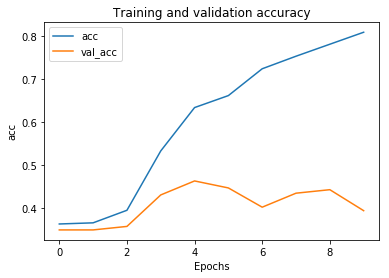

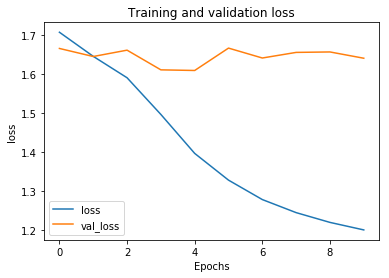

In [31]:
plotGraphs(history, 'acc')
plotGraphs(history, 'loss')

### Increasing Model Architecture and Applying Regularization

In [32]:
# new model architecture with extra LSTM layer
# and addition of dropouts
out_dim = 128
n_units = 32
vocab_size = vocab_size
model = Sequential()
model.add(Embedding(vocab_size, out_dim, input_length=seq_len))
model.add(LSTM(n_units, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(n_units))
model.add(layers.Dropout(0.2))
model.add(Dense(n_units, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))  

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 128)           313216    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 32)            20608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
__________

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', metrics= ['accuracy'])

In [35]:
# training model for 5 epochs
history = model.fit(train_texts, label_train,
                   batch_size=128, epochs=10,
                   validation_data=(val_texts, label_val))

Train on 754 samples, validate on 246 samples
Epoch 1/10
754/754 [==============================] - 80s 106ms/step - loss: 1.7578 - acc: 0.3011 - val_loss: 1.6902 - val_acc: 0.3496
Epoch 2/10
754/754 [==============================] - 10s 13ms/step - loss: 1.6839 - acc: 0.3103 - val_loss: 1.6639 - val_acc: 0.3496
Epoch 3/10
754/754 [==============================] - 11s 14ms/step - loss: 1.6812 - acc: 0.3210 - val_loss: 1.6578 - val_acc: 0.3496
Epoch 4/10
754/754 [==============================] - 10s 13ms/step - loss: 1.6627 - acc: 0.3249 - val_loss: 1.6557 - val_acc: 0.3496
Epoch 5/10
754/754 [==============================] - 10s 13ms/step - loss: 1.6538 - acc: 0.3276 - val_loss: 1.6602 - val_acc: 0.3496
Epoch 6/10
754/754 [==============================] - 10s 13ms/step - loss: 1.6341 - acc: 0.3660 - val_loss: 1.6435 - val_acc: 0.3659
Epoch 7/10
754/754 [==============================] - 10s 13ms/step - loss: 1.5876 - acc: 0.3966 - val_loss: 1.7363 - val_acc: 0.3496
Epoch 8/10
754/

In [36]:
model.save('sentiment_analysis_02.h5')

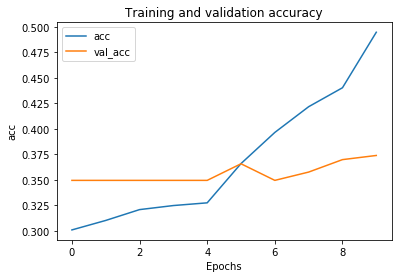

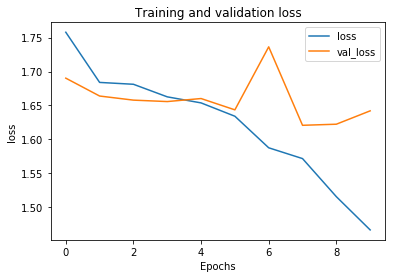

In [37]:
# plotting training and validation accuracy and losses
plotGraphs(history, 'acc')
plotGraphs(history, 'loss')

### Model Evaluation with Acc@1 and AP: average Pearson correlation coefficient

In [38]:
# loading learned parameters from model
model = load_model('sentiment_analysis_02.h5')

In [39]:
# get predicted values
prediction = model.predict(test)

In [40]:
y = labels
y_hat = prediction

### Acc@1

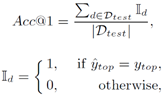


In [41]:
def acc1(y, y_hat):
    return sum(_index(y, y_hat)
              ) / len(y_hat)

def _index(y, y_hat):
    acc_1 = []
    for idx in range(len(y_hat)):
        if np.argmax(y_hat[idx]) == np.argmax(
            y[idx]):
            i_d = 1
        else:
            i_d = 0
        acc_1.append(i_d)
    return acc_1

In [42]:
print('Acc@1 =', acc1(y, y_hat))

Acc@1 = 0.3008130081300813


#### AP: average Pearson correlation coefficient  
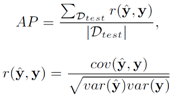

𝑟 is the Pearson correlation coefficient between the predicted emotion distribution 
y^ and the ground truth distribution y. cov denotes the covariance operation.
var denotes variance.

In [43]:
def avgPearsonCorrelationCoefficient(y, y_hat):
    return sum(_pearson_correlation_coefficient(y, y_hat)
              ) / len(y_hat)

def _pearson_correlation_coefficient(y, y_hat):
    r = []
    for idx in range(len(y_hat)):
        # pearson correlation coefficients with
        # pearsonr from scipy library
        value = pearsonr(y[idx], y_hat[idx])
        pear_coeff, p_value = value
        r.append(pear_coeff)
    return r

In [44]:
print('Average Pearson Correlation Coefficient =',
      avgPearsonCorrelationCoefficient(y, y_hat))

Average Pearson Correlation Coefficient = 0.22860043508282063


### Saving Model Predictions as Text Document

In [45]:
def saveEmotions(file_name, prediction):
    # saving predictions
    predicted = _label_to_string(prediction)
    with open(file_name, 'w') as text:
        for i in predicted:
            text.write("%s\n" % i)

def _label_to_string(prediction):
    #stringify each label 
    predicted = [' '.join(str(round(num,3)) for num in c) 
                 for c in prediction.tolist()]
    return predicted

In [46]:
saveEmotions('emotion.txt', prediction)